In [49]:
# Step 1: Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from scipy.stats import zscore

In [50]:
# Step 2: Load the dataset 
df = pd.read_csv("raw_iot_data.csv", encoding='utf-8-sig')

In [51]:
# Step 3: Clean column names 
df.columns = df.columns.str.strip().str.lower()

In [52]:
# Step 4: Inspect the columns 
print("✅ Columns in the dataset:", df.columns.tolist())
display(df.head())

✅ Columns in the dataset: ['timestamp', 'device_id', 'data_type', 'data_value']


,timestamp,device_id,data_type,data_value
0,2025-03-04 20:41:46.466097,Device_4,Energy,22.5°C
1,2025-03-04 21:41:46.466095,Device_5,Humidity,45%
2,2025-03-04 22:41:46.466093,Device_3,Temperature,18.3 kWh
3,2025-03-04 23:41:46.466090,Device_5,Humidity,NaN
4,2025-03-05 00:41:46.466089,Device_5,Humidity,23.1°C


In [53]:
# Step 5: Handle missing values 
for col in df.columns:
    if df[col].dtype in ['float64', 'int64']:
        df[col] = df[col].fillna(df[col].median())
    else:
        df[col] = df[col].fillna('Unknown')

In [54]:
# Step 6: Extract numeric values from 'data_value' 
def extract_numeric(value):
    if isinstance(value, str):
        match = re.search(r"[-+]?[0-9]*\.?[0-9]+", value)
        return float(match.group()) if match else None
    return value

df['value'] = df['data_value'].apply(extract_numeric)


In [55]:
# Step 7: Convert 'timestamp' column to datetime and set as index 
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.set_index('timestamp', inplace=True)

In [56]:
# Step 8: Pivot the 'data_type' column into separate columns
pivot_df = df.pivot_table(index='timestamp', columns='data_type', values='value', aggfunc='mean')

In [57]:
# Step 9: Resample by hour (h) and calculate averages 
hourly_df = pivot_df.resample('h').mean()

In [60]:
# Step 10: Check for duplicates 
print("🟡 Duplicate rows found:", df.duplicated().sum())
df = df.drop_duplicates()

🟡 Duplicate rows found: 0


In [61]:
# Step 11: Outlier detection using Z-score 
z_scores = hourly_df.apply(zscore)
outliers = (np.abs(z_scores) > 3)
print("🔍 Outliers detected per column:")
print(outliers.sum())

🔍 Outliers detected per column:
data_type
Energy         0
Humidity       0
Temperature    0
dtype: int64


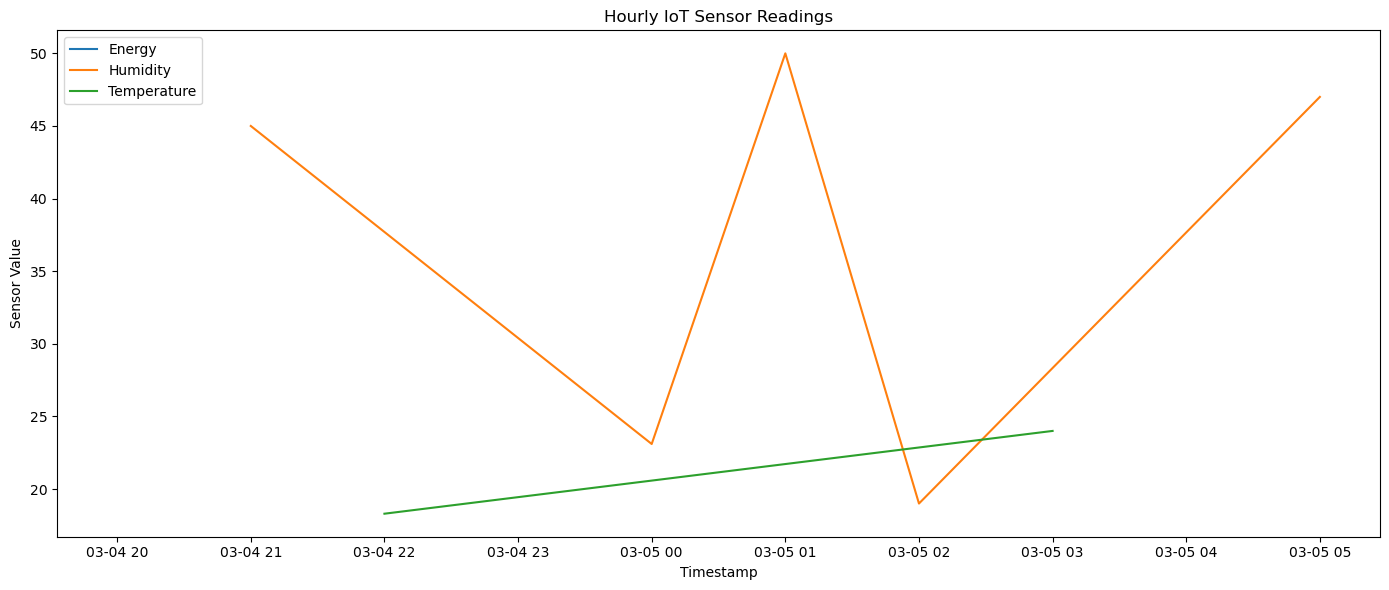

In [62]:
# Step 12: Plot hourly trends 
plt.figure(figsize=(14, 6))
for col in hourly_df.columns:
    sns.lineplot(data=hourly_df[col], label=col)

plt.title("Hourly IoT Sensor Readings")
plt.xlabel("Timestamp")
plt.ylabel("Sensor Value")
plt.legend()
plt.tight_layout()
plt.show()

In [63]:
hourly_df.to_csv("cleaned_hourly_iot_data.csv")